# inception resnet v2 block8_5_mixed finetuning, augmentation, learning rate decay, global average pooling, input_size=(500,500), dropout(0.2)

In [1]:
import os
import numpy as np
import tensorflow as tf

# gpu 문제로 코드가 안돌아가는 상황이 있어서 set_memory_growth 셋팅을 설정해준 코드
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
data_path = "food_data_v2"
train_path = os.path.join(data_path, 'train')
val_path = os.path.join(data_path, 'val')
test_path = os.path.join(data_path, 'test')

In [3]:
train_len = 0
for i in os.listdir(train_path):
    train_len += len(os.listdir( os.path.join( train_path, i) ))

val_len = 0
for i in os.listdir(val_path):
    val_len += len(os.listdir( os.path.join( val_path, i) ))

test_len = 0
for i in os.listdir(test_path):
    test_len += len(os.listdir( os.path.join( test_path, i) ))

print(f"train : {train_len}, val : {val_len}, test : {test_len}")

train : 5250, val : 1750, test : 1750


In [4]:
# ImageDataGenerator를 통해 이미지를 원하는 shape으로 불러오고 augmentation 해줄 수 있음
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 0~1 정규화
test_gen = ImageDataGenerator(rescale=1./255)
# 데이터 augmentation
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=100,
    width_shift_range=0.4,
    height_shift_range=0.4,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2
)

# flow_from_directory를 통해서 폴더에 분류 있는 데이터들을 레이블과 함께 얻어올 수 있음
train_data = data_gen.flow_from_directory(
    train_path, class_mode='categorical', color_mode='rgb',
    shuffle=True, target_size=(500,500), batch_size=100 # 5250
)
val_data = test_gen.flow_from_directory(
    val_path, class_mode='categorical', color_mode='rgb',
    shuffle=True, target_size=(500,500), batch_size=50 # 1750
)
test_data = test_gen.flow_from_directory(
    test_path, class_mode='categorical', color_mode='rgb',
    shuffle=True, target_size=(500,500), batch_size=50 # 1750
)

Found 5250 images belonging to 35 classes.
Found 1750 images belonging to 35 classes.
Found 1750 images belonging to 35 classes.


In [5]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
inception_model = InceptionResNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(500,500,3)
)

In [6]:
inception_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500, 500, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 249, 249, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 249, 249, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 249, 249, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

In [7]:
inception_model.trainable = False

set_trainable = False
for layer in inception_model.layers:
    if layer.name == "block8_5_mixed":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [8]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

layer1 = GlobalAveragePooling2D()(inception_model.output)
layer2 = Dropout(0.2)(layer1)
output = Dense(35, activation='softmax')(layer2)

model = Model(inception_model.input, output)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500, 500, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 249, 249, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 249, 249, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 249, 249, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(0.1 * (10-epoch))

checkpoint_filepath = 'model/500_drop/{epoch:02d}-{val_accuracy:.5f}.h5'
model_checkpoint_callback = [
    ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='auto'),
    tf.keras.callbacks.LearningRateScheduler(scheduler)
]

In [11]:
history = model.fit(train_data, steps_per_epoch=5250 // 100, epochs=25,\
    validation_data=val_data, validation_steps=1750 // 50, callbacks=model_checkpoint_callback)

Epoch 1/25
52/52 [==============================] - ETA: 0s - loss: 1.2485 - accuracy: 0.6447

C:\Users\Owner6\Anaconda3\envs\jh\lib\site-packages\PIL\TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


52/52 [==============================] - 338s 6s/step - loss: 1.2485 - accuracy: 0.6447 - val_loss: 1.3549 - val_accuracy: 0.6640

Epoch 00001: val_accuracy improved from -inf to 0.66400, saving model to model/500_drop\01-0.66400.h5
Epoch 2/25
52/52 [==============================] - 313s 6s/step - loss: 0.5970 - accuracy: 0.8210 - val_loss: 1.0840 - val_accuracy: 0.6960

Epoch 00002: val_accuracy improved from 0.66400 to 0.69600, saving model to model/500_drop\02-0.69600.h5
Epoch 3/25
52/52 [==============================] - 324s 6s/step - loss: 0.4055 - accuracy: 0.8740 - val_loss: 0.6095 - val_accuracy: 0.8326

Epoch 00003: val_accuracy improved from 0.69600 to 0.83257, saving model to model/500_drop\03-0.83257.h5
Epoch 4/25
52/52 [==============================] - 324s 6s/step - loss: 0.3273 - accuracy: 0.9027 - val_loss: 0.6887 - val_accuracy: 0.8126

Epoch 00004: val_accuracy did not improve from 0.83257
Epoch 5/25
52/52 [==============================] - 310s 6s/step - loss: 0.2

In [12]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

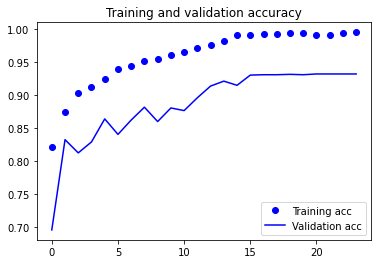

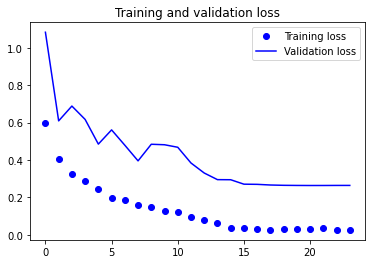

In [13]:
# 학습 과정의 accuracy와 loss 값을 plot
import matplotlib.pyplot as plt

acc = history.history['accuracy'][1:]
val_acc = history.history['val_accuracy'][1:]
loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
model.evaluate(test_data, steps=1750//50)

35/35 [==============================] - 19s 526ms/step - loss: 0.2214 - accuracy: 0.9423


[0.22139346599578857, 0.9422857165336609]